# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [90]:
# Import modules
import pandas as pd
import numpy as np
import os
import requests
import json
from timeit import default_timer as timer
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from importlib import reload
from matplotlib.font_manager import FontProperties
import seaborn as sns
from IPython.display import display


%matplotlib inline
# Display mac column width
pd.set_option('display.max_colwidth', None)

# Maximise number of displayed columns
pd.set_option('display.max_columns', None)

# Load downloaded twitter data into a dataframe
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [91]:
import requests

# URL of the file to download
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Get the file name from the URL
    file_name = url.split("/")[-1]

    # Save the file to the local directory
    with open(file_name, "wb") as file:
        file.write(response.content)
    print("Download OK")
else:
    print("Download error")

df_image_prediction = pd.read_csv('C:\\Users\\huylc1\\Downloads\\image-predictions.tsv', sep='\t')
df_image_prediction.head()

Download OK


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [92]:
# Do not have a Twitter account so I decided to use "tweet_json.txt" from supporting materials.

# Read this tweet_json.txt file line by line
tweet_data = []
with open('C:\\Users\\huylc1\\Downloads\\tweet_json.txt', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        tweet_data.append({
            'tweet_id': tweet['id'],
            'retweet_count': tweet['retweet_count'],
            'favorite_count': tweet['favorite_count']
        })

# Create a DataFrame from the tweet data
df_tweet_json = pd.DataFrame(tweet_data, columns=['tweet_id', 'retweet_count', 'favorite_count'])

# Display the DataFrame
print(df_tweet_json.head())

error_tweets = df_twitter_archive.query('tweet_id != {}'.format(df_tweet_json['tweet_id'].to_list()))
error_tweets.head()

# Show error_tweets info
error_tweets.info()

             tweet_id  retweet_count  favorite_count
0  892420643555336193           8853           39467
1  892177421306343426           6514           33819
2  891815181378084864           4328           25461
3  891689557279858688           8964           42908
4  891327558926688256           9774           41048
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 19 to 815
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2 non-null      int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   2 non-null      object 
 4   source                      2 non-null      object 
 5   text                        2 non-null      object 
 6   retweeted_status_id         2 non-null      float64
 7   retweeted_status_user_id    2 non-null      float64
 8   ret

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [93]:
# Assess Twitter archive data

df_twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None


In [94]:
# Inspect datatypes of data set
df_twitter_archive.dtypes

tweet_id                        int64
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

In [95]:
df_twitter_archive.rating_denominator.value_counts() 

10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
0         1
90        1
40        1
130       1
110       1
16        1
120       1
2         1
Name: rating_denominator, dtype: int64

In [96]:
# Check for missing values in all columns:
df_twitter_archive.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [97]:
# Get the value counts of the rating_numerator and rating_denominator columns
numerator_counts = df_twitter_archive['rating_numerator'].value_counts().sort_index()
denominator_counts = df_twitter_archive['rating_denominator'].value_counts().sort_index()

print("Value counts for rating_numerator:")
print(numerator_counts)
print()

print("Value counts for rating_denominator:")
print(denominator_counts)

Value counts for rating_numerator:
0         2
1         9
2         9
3        19
4        17
5        37
6        32
7        55
8       102
9       158
10      461
11      464
12      558
13      351
14       54
15        2
17        1
20        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        2
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
182       1
204       1
420       2
666       1
960       1
1776      1
Name: rating_numerator, dtype: int64

Value counts for rating_denominator:
0         1
2         1
7         1
10     2333
11        3
15        1
16        1
20        2
40        1
50        3
70        1
80        2
90        1
110       1
120       1
130       1
150       1
170       1
Name: rating_denominator, dtype: int64


The majority of the rating_numerator seem to be within the range of 0 to 20. Ratings above this range could be considered as outliers.
The majority of the rating_denominator have a denominator of 10, which is the expected scale. Denominators which are not 10 could be considered as outliers.

In [98]:
# Assess image prediction data visually

df_image_prediction

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In the dog type prediction, there are certain rows where all the prediction values are False, indicating that they likely correspond to animals other than dogs. These rows are not relevant to our research, which specifically focuses on dog predictions.

Additionally, there are some rows where there are multiple True predictions, indicating the possibility of multiple dog types. However, for the purpose of this research, we should limit the prediction to the dog type with the highest confidence level.

In [99]:
# Inspect datatypes of data set

df_image_prediction.dtypes

tweet_id      int64
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

In [100]:
# Export the DataFrame df_image_prediction to a CSV file
df_image_prediction.to_csv('image_prediction.csv', index=False)

In [101]:
df_image_prediction.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [102]:
# Assess tweet data
df_tweet_json

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


In [103]:
# Export to a CSV file
df_tweet_json.to_csv('tweet_data.csv', index=False)

In [104]:
df_tweet_json.isnull().sum()

tweet_id          0
retweet_count     0
favorite_count    0
dtype: int64

### Quality issues
#### Twitter dataset:
1. "timestamp" and "retweeted_status_timestamp" columns have data type object

2. In the "name" column, there are some entries that appear to be missing or incorrectly captured names, such as "None", "a", "an", "the", "all", etc
       
3. The dataset includes retweets and replies, but we are only interested in original tweets for our analysis

4. There are tweets in the dataset that do not have accompanying images of dogs and they are not relevant for our purposes

5.  Rating_numerator and rating_denominator are not approriate


#### Image prediction dataset:

6. There are rows with no prediction of a dog (neither in 1, 2 nor 3)

7. In the image prediction data, there are multiple corresponding confidence levels for each dog prediction

8. There is a "_" instead of a whitespace in the predictions

### Tidiness issues
1. All three tables share the column tweet_id and should be merged together


2. Some records have more than one dog stage

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [105]:
# Make copies of original pieces of data
df_twitter_archive_copy = df_twitter_archive.copy()
df_image_prediction_copy = df_image_prediction.copy()
df_tweet_json_copy = df_tweet_json.copy()

### Quality issue 

#### ＃1: "timestamp" and "retweeted_status_timestamp" columns have data type object

#### Define
To convert the "timestamp" and "retweeted_status_timestamp" columns to the appropriate data type, which is datetime, you can use the pd.to_datetime() function in pandas. 

#### Code

In [106]:
df_twitter_archive_copy['timestamp'] = pd.to_datetime(df_twitter_archive_copy['timestamp'])
df_twitter_archive_copy['retweeted_status_timestamp'] = pd.to_datetime(df_twitter_archive_copy['retweeted_status_timestamp'])

#### Test
To check the data types of "timestamp" and "retweeted_status_timestamp" columns:

In [107]:
df_twitter_archive_copy.dtypes

tweet_id                                    int64
in_reply_to_status_id                     float64
in_reply_to_user_id                       float64
timestamp                     datetime64[ns, UTC]
source                                     object
text                                       object
retweeted_status_id                       float64
retweeted_status_user_id                  float64
retweeted_status_timestamp    datetime64[ns, UTC]
expanded_urls                              object
rating_numerator                            int64
rating_denominator                          int64
name                                       object
doggo                                      object
floofer                                    object
pupper                                     object
puppo                                      object
dtype: object

#### #2: In the "name" column, there are some entries that appear to be missing or incorrectly captured names, such as "None", "a", "an", "the", "all", etc


#### Define
We find inproriate names which are None or not an upper case string and change to "Unknown".

#### Code

In [108]:
names = df_twitter_archive_copy.loc[df_twitter_archive_copy['name'].str.islower(), 'name']
name_counts = names.value_counts()
print(name_counts)

a               55
the              8
an               7
very             5
just             4
quite            4
one              4
getting          2
actually         2
mad              2
not              2
old              1
life             1
officially       1
light            1
by               1
infuriating      1
such             1
all              1
unacceptable     1
this             1
his              1
my               1
incredibly       1
space            1
Name: name, dtype: int64


In [109]:
# Replace lower case names with "Unknown"
df_twitter_archive_copy['name'] = df_twitter_archive_copy['name'].apply(lambda x: 'Unknown' if x.islower() else x)
df_twitter_archive_copy['name'].replace('None', 'Unknown', inplace=True)
df_twitter_archive_copy

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaT,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaT,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,Unknown,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaT,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,Unknown,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaT,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,Unknown,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaT,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,Unknown,None,None,None,None


#### Test
To check if there are no lowercase values left in the 'name' column of the df_twitter_archive_copy:

In [110]:
lowercase_names = df_twitter_archive_copy['name'][df_twitter_archive_copy['name'].str.islower()]
print(lowercase_names)

Series([], Name: name, dtype: object)


#### #3: The dataset includes retweets and replies, but we are only interested in original tweets for our analysis

#### Define
We find and drop rows which have retweets and replies from the df_twitter_archive_copy DataFrame


#### Code

In [111]:
# Find rows with retweets
retweets = df_twitter_archive_copy[df_twitter_archive_copy['retweeted_status_id'].notnull()]

# Find rows with replies
replies = df_twitter_archive_copy[df_twitter_archive_copy['in_reply_to_status_id'].notnull()]

# Drop rows with retweets and replies
df_twitter_archive_copy = df_twitter_archive_copy.drop(retweets.index)
df_twitter_archive_copy = df_twitter_archive_copy.drop(replies.index)

#### Test

In [112]:
# Check if there are any rows with retweets
retweet_rows = df_twitter_archive_copy[df_twitter_archive_copy['retweeted_status_id'].notnull()]
if not retweet_rows.empty:
    print("There are rows with retweets.")

# Check if there are any rows with replies
reply_rows = df_twitter_archive_copy[df_twitter_archive_copy['in_reply_to_status_id'].notnull()]
if not reply_rows.empty:
    print("There are rows with replies.")

#### #4: There are tweets in the dataset that do not have accompanying images of dogs and they are not relevant for our purposes

#### Define
We find and drop rows which do not have accompanying images of dogs

#### Code

In [113]:
df_twitter_archive_copy.dropna(subset=['expanded_urls'], inplace=True)

#### Test

In [114]:
# To check if there are any remaining rows in the df_twitter_archive_copy DataFrame where the expanded_urls column is null
null_urls = df_twitter_archive_copy[df_twitter_archive_copy['expanded_urls'].isnull()]
if null_urls.empty:
    print("There are no rows with null values in the expanded_urls column.")
else:
    print("There are still rows with null values in the expanded_urls column.")


There are no rows with null values in the expanded_urls column.


#### #6: Rating_numerator and rating_denominator are not approriate

#### Define 
The majority of the rating_numerator seem to be within the range of 0 to 20. Ratings above this range could be considered as outliers.
The majority of the rating_denominator have a denominator of 10, which is the expected scale. Denominators which are not 10 could be considered as outliers.

#### Code

In [115]:
df_twitter_archive_copy.drop(df_twitter_archive_copy[df_twitter_archive_copy['rating_numerator'] > 20].index, inplace=True)
df_twitter_archive_copy.drop(df_twitter_archive_copy[df_twitter_archive_copy['rating_denominator'] != 10].index, inplace=True)

#### Test

In [116]:
df_twitter_archive_copy['rating_numerator'].value_counts()

12    485
10    434
11    413
13    287
9     152
8      98
7      51
14     38
5      34
6      32
3      19
4      15
2       9
1       4
0       1
Name: rating_numerator, dtype: int64

In [117]:
df_twitter_archive_copy['rating_denominator'].value_counts()

10    2072
Name: rating_denominator, dtype: int64

### Image Prediction Dataset

#### #6: There are rows with no prediction of a dog (neither in 1, 2 nor 3)

#### Define
Remove the rows from the df_image_prediction DataFrame where none of the three image predictions indicate a dog

#### Code

In [118]:
df_image_prediction_copy = df_image_prediction_copy[~((df_image_prediction_copy['p1_dog'] == False) & (df_image_prediction_copy['p2_dog'] == False) & (df_image_prediction_copy['p3_dog'] == False))]

#### Test

In [119]:
no_dog_predictions = df_image_prediction_copy[(df_image_prediction_copy['p1_dog'] == False) & (df_image_prediction_copy['p2_dog'] == False) & (df_image_prediction_copy['p3_dog'] == False)]

if len(no_dog_predictions) == 0:
    print("There are no rows where none of the image predictions indicate a dog.")
else:
    print("There are rows where none of the image predictions indicate a dog.")

There are no rows where none of the image predictions indicate a dog.


#### #7:  In the image prediction data, there are multiple corresponding confidence levels for each dog prediction

#### Define
First create two new blank columns 'highest_confidence' and 'dog_type'. Then identify dogs with only 1 TRUE value in the dog prediction columns and assigns the corresponding dog type to the 'dog_type' column.

Next, identify dogs with 2 or more TRUE values in the dog prediction columns, and for those dogs, find the highest confidence value and assigns it to the 'highest_confidence' column. I also assign the corresponding dog type to the 'dog_type' column, considering only the dog types.

After updating the relevant columns, the code proceeds to drop the original prediction columns ('p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'). The reason for dropping these columns is that they are no longer needed after extracting the highest confidence level and dog type.

#### Code

In [120]:
# Create blank columns for highest_confidence and dog_type
df_image_prediction_copy['highest_confidence'] = ''
df_image_prediction_copy['dog_type'] = ''

# Check each row to find the dog type if only one of the three columns has a TRUE value
for index, row in df_image_prediction_copy.iterrows():
    dog_type_count = sum([row['p1_dog'], row['p2_dog'], row['p3_dog']])
    if dog_type_count == 1:
        if row['p1_dog']:
            df_image_prediction_copy.at[index, 'dog_type'] = row['p1']
        elif row['p2_dog']:
            df_image_prediction_copy.at[index, 'dog_type'] = row['p2']
        else:
            df_image_prediction_copy.at[index, 'dog_type'] = row['p3']


In [123]:

# Check each row to find the dog type and highest confidence level
for index, row in df_image_prediction_copy.iterrows():
    dog_type_count = sum([row['p1_dog'], row['p2_dog'], row['p3_dog']])
    if dog_type_count >= 2:
        # Get the indices of the columns where p1_dog, p2_dog, and p3_dog are TRUE
        true_indices = [i for i, value in enumerate([row['p1_dog'], row['p2_dog'], row['p3_dog']]) if value]
        
        # Get the corresponding confidence levels and dog types for the true indices
        conf_levels = [row[f'p{i+1}_conf'] for i in true_indices]
        dog_types = [row[f'p{i+1}'] for i in true_indices]
        
        # Find the index of the highest confidence level
        max_index = conf_levels.index(max(conf_levels))
        
        # Assign the highest confidence level and corresponding dog type to the new columns
        df_image_prediction_copy.at[index, 'highest_confidence'] = conf_levels[max_index]
        df_image_prediction_copy.at[index, 'dog_type'] = dog_types[max_index]

#### Test

In [124]:
df_image_prediction_copy

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,highest_confidence,dog_type
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,0.465074,Welsh_springer_spaniel
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,0.506826,redbone
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,0.596461,German_shepherd
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,0.408143,Rhodesian_ridgeback
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,0.560311,miniature_pinscher
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2069,891087950875897856,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,0.425595,Chesapeake_Bay_retriever
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,0.555712,basset
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,,Labrador_retriever
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,0.716012,Chihuahua


#### #8: There is a "_" instead of a whitespace in the predictions

#### Define 
Replace the underscore character "_" with a whitespace in the 'dog_type' column of the df_image_prediction_copy DataFrame

#### Code

In [125]:
df_image_prediction_copy['dog_type'] = df_image_prediction_copy['dog_type'].str.replace('_', ' ')

#### Test

In [126]:
df_image_prediction_copy

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,highest_confidence,dog_type
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,0.465074,Welsh springer spaniel
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,0.506826,redbone
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,0.596461,German shepherd
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,0.408143,Rhodesian ridgeback
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,0.560311,miniature pinscher
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2069,891087950875897856,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,0.425595,Chesapeake Bay retriever
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,0.555712,basset
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,,Labrador retriever
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,0.716012,Chihuahua


### Tidiness issues

#### #1: All three tables share the column tweet_id and should be merged together

#### Define 
Merge 3 DF into new twitter_archive_master DF

#### Code

In [127]:
twitter_archive_master = df_twitter_archive_copy.merge(df_tweet_json_copy, on='tweet_id').merge(df_image_prediction_copy, on='tweet_id')
twitter_archive_master

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,highest_confidence,dog_type
0,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None,6514,33819,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,0.323581,Chihuahua
1,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None,4328,25461,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,0.716012,Chihuahua
2,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None,8964,42908,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,,Labrador retriever
3,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaT,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None,9774,41048,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,0.555712,basset
4,891087950875897856,NaN,NaN,2017-07-29 00:08:17+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,Unknown,None,None,None,None,3261,20562,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,0.425595,Chesapeake Bay retriever
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1642,666049248165822465,NaN,NaN,2015-11-16 00:24:50+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaT,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,Unknown,None,None,None,None,41,111,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,0.560311,miniature pinscher
1643,666044226329800704,NaN,NaN,2015-11-16 00:04:52+00:00,"<a href=

#### #2: Some records have more than one dog stage

#### Define
Create a new 'dog_stage' column to indicate the dog stage of each dog. Then find dogs with only one of the 4 values is not 'None', these are considered to be their known dog type. Records have more than one dog stage is considered to be 'None'.
Drop columns like 'doggo', 'floofer', 'pupper', 'puppo' because these columns have been merged into a single column 'dog_stage' and so on are no longer needed in the analysis. 

#### Code

In [128]:
df_twitter_archive_copy['dog_stage'] = ''

# If all 4 columns have 'None', set 'dog_stage' as 'None'
df_twitter_archive_copy.loc[df_twitter_archive_copy[['doggo', 'floofer', 'pupper', 'puppo']].eq('None').all(axis=1), 'dog_stage'] = 'None'

# If only one of the 4 columns is not 'None', set 'dog_stage' as the non-'None' value
for column in ['doggo', 'floofer', 'pupper', 'puppo']:
    df_twitter_archive_copy.loc[df_twitter_archive_copy[column] != 'None', 'dog_stage'] = df_twitter_archive_copy[column]

# If there are 2 or 1 'None' values in the 4 columns, set 'dog_stage' as 'None'
df_twitter_archive_copy.loc[df_twitter_archive_copy[['doggo', 'floofer', 'pupper', 'puppo']].eq('None').sum(axis=1) <= 2, 'dog_stage'] = 'None'

# Drop the 'doggo', 'floofer', 'pupper', 'puppo' columns
df_twitter_archive_copy.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

#### Test

In [129]:
df_twitter_archive_copy.value_counts('dog_stage')

dog_stage
None       1749
pupper      219
doggo        72
puppo        23
floofer       9
dtype: int64

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [130]:
twitter_archive_master.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

### Insights:
#### Question 1: Which dog types get retweeted and favorited the most overall?

We will first examine the frequency of each dog breed in the dataset. Then, we will create a groupby object to calculate the total favorite and retweet counts for each breed. By analyzing this data, we determine top 10 types receiving the highest number of retweets and favorites overall.

<Figure size 1000x600 with 0 Axes>

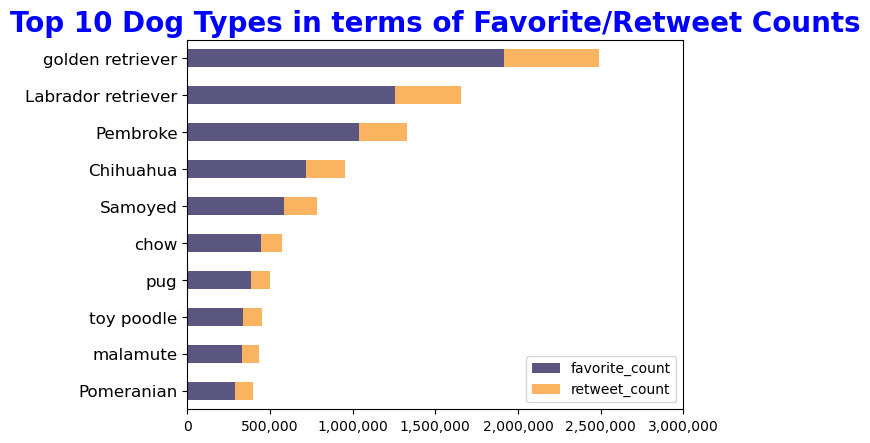

In [131]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Calculate the frequency of each dog type
type_counts = twitter_archive_master['dog_type'].value_counts().head(10)

# Group the data by dog type and calculate the total favorite and retweet counts
type_group = twitter_archive_master.groupby('dog_type')[['favorite_count', 'retweet_count']].sum()

# Convert dog_type values to uppercase for the first initial
twitter_archive_master['dog_type'] = twitter_archive_master['dog_type'].str.title()

# Filter the type_group to include only the top 10 dog types
type_group_top10 = type_group.loc[type_counts.index]

# Sort the type_group_top10 by favorite count in descending order
type_group_top10_sorted = type_group_top10.sort_values(by='favorite_count', ascending=False)

# Create a horizontal bar plot for the top 10 dog types with two patterns for favorite count and retweet count
plt.figure(figsize=(10, 6))
ax = type_group_top10_sorted[['favorite_count', 'retweet_count']].plot(kind='barh', stacked=True,
                                                                      color=['#140F4B', '#F7931E'],
                                                                      alpha=0.7)

# Add dog names on the vertical axis
ax.set_yticks(range(len(type_group_top10_sorted.index)))
ax.set_yticklabels(type_group_top10_sorted.index, fontsize=12)

plt.title('Top 10 Dog Types in terms of Favorite/Retweet Counts', fontsize=20, fontweight='bold', color='blue')

# Invert the y-axis to have the top dog at the upper part of the plot
plt.gca().invert_yaxis()

# Display the count values on the horizontal axis
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks()])

plt.show()

In [132]:
display(type_group_top10)

,favorite_count,retweet_count
golden retriever,1914145,574953
Labrador retriever,1253364,399853
Pembroke,1038797,291771
Chihuahua,717450,235679
pug,383817,118682
toy poodle,337270,115330
chow,443610,129921
Samoyed,583906,203446
Pomeranian,291008,104774
malamute,332859,102515


The graph showcases the top 10 dog types ranked by their favorite count and retweet count on Twitter.

The top dog type is the Golden Retriever, with a remarkable total of nearly 2.5 million engagements. The Labrador Retriever comes in a close second with a substantial number of favorites and retweets.

Other popular breeds in the list include the Pembroke, Chihuahua, Pug, Toy Poodle, Chow, Samoyed, Pomeranian, and Malamute, each with their own significant engagement on social media.

These findings emphasize the strong online presence and engagement of these dog breeds on Twitter. Understanding the preferences and trends among Twitter users can be valuable for pet industry marketing and branding strategies.

#### Question 2: Is there a relationship between retweets and favorites?
To answer the question of whether there is a relationship between retweets and favorites, you can calculate the correlation coefficient between the two variables. A positive correlation suggests that as the number of retweets increases, the number of favorites also tends to increase.

Correlation between retweet count and favorite count: 0.9133863255897605


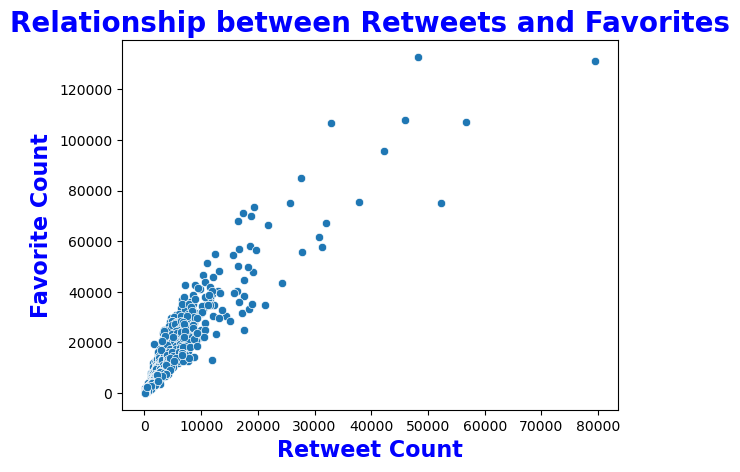

In [133]:
# Calculate the correlation coefficient between retweet count and favorite count
corr = twitter_archive_master['retweet_count'].corr(twitter_archive_master['favorite_count'])

# Print the correlation coefficient
print("Correlation between retweet count and favorite count:", corr)

# Create a scatter plot to visualize the relationship between retweets and favorites
sns.scatterplot(data=twitter_archive_master, x='retweet_count', y='favorite_count')
plt.xlabel('Retweet Count', fontweight='bold', color='blue', fontsize=16)
plt.ylabel('Favorite Count', fontweight='bold', color='blue', fontsize=16)
plt.title('Relationship between Retweets and Favorites', fontsize=20, fontweight='bold', color='blue')
plt.show()


The correlation coefficient between retweet count and favorite count was calculated to be 0.9134, indicating a strong positive correlation between these two variables. This suggests that tweets with a higher number of retweets tend to also have a higher number of favorites, and vice versa.

In terms of marketing, this finding highlights the importance of user engagement on social media platforms. When a tweet receives a high number of retweets, it is likely to attract a higher number of favorites as well. This indicates that the content of the tweet resonates with the audience, leading to increased interaction and engagement.

Understanding this correlation can help marketers optimize their social media strategies. By creating engaging and shareable content that encourages users to retweet, brands can increase the likelihood of their tweets being favorited as well. This can enhance brand visibility, attract a larger audience, and potentially lead to higher conversion rates and customer loyalty.

It's worth noting that correlation does not imply causation, and other factors may influence the relationship between retweet count and favorite count. Further analysis is recommended to explore the underlying drivers of this correlation and identify specific strategies to leverage it effectively in marketing campaigns.

In conclusion, the strong positive correlation between retweet count and favorite count emphasizes the significance of user engagement on social media platforms for marketing success. By focusing on creating compelling and shareable content, businesses can harness this correlation to enhance their brand reach and connect with their target audience.

#### Question 3: Is there a relationship between the rating of the dogs and the engagement (retweet and favorite counts) they receive on Twitter?
To answer this question, we'll analyze the data in the provided columns: rating_numerator, retweet_count, and favorite_count. We'll calculate the correlation between the rating numerator and the retweet/favorite counts to determine if there's any association between the two variables. Additionally, we can create visualizations such as scatter plots to visualize the relationship between the ratings and the engagement metrics.

Correlation between rating numerator and retweet count: 0.32166498125189397
Correlation between rating numerator and favorite count: 0.42658497435658954


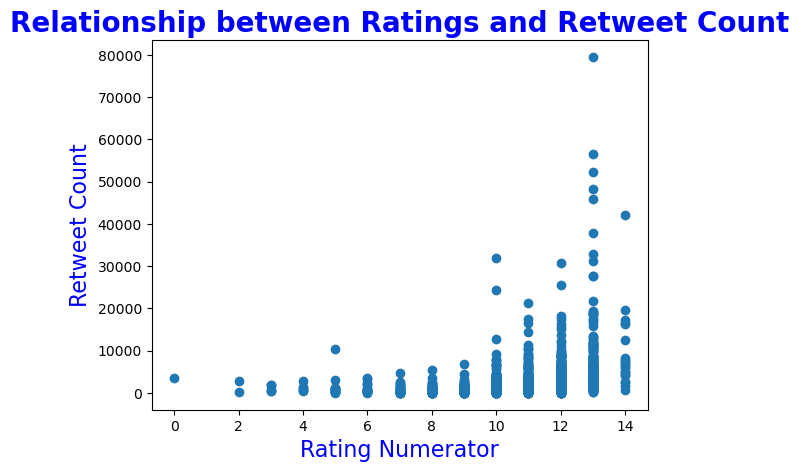

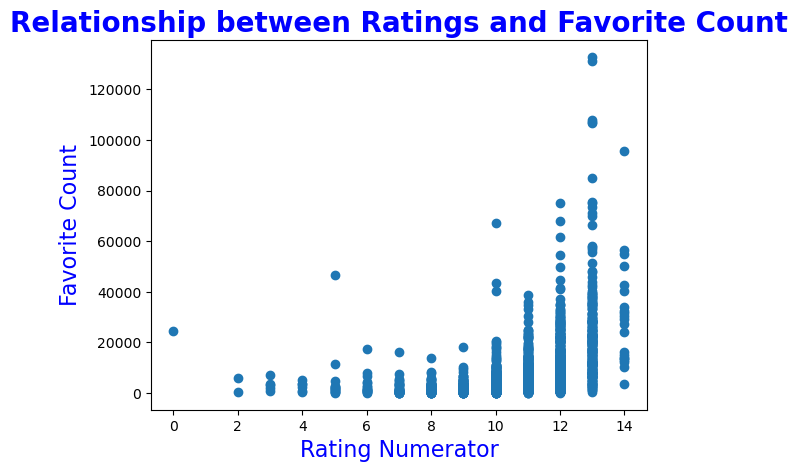

In [134]:
# Calculate the correlation between rating numerator and retweet count
rating_retweet_corr = twitter_archive_master['rating_numerator'].corr(twitter_archive_master['retweet_count'])

# Calculate the correlation between rating numerator and favorite count
rating_favorite_corr = twitter_archive_master['rating_numerator'].corr(twitter_archive_master['favorite_count'])

# Print the correlation coefficients
print("Correlation between rating numerator and retweet count:", rating_retweet_corr)
print("Correlation between rating numerator and favorite count:", rating_favorite_corr)

# Create a scatter plot of rating numerator vs. retweet count
plt.scatter(twitter_archive_master['rating_numerator'], twitter_archive_master['retweet_count'])
plt.xlabel('Rating Numerator', color='blue', fontsize=16)
plt.ylabel('Retweet Count', color='blue', fontsize=16)
plt.title('Relationship between Ratings and Retweet Count', fontweight='bold', color='blue', fontsize=20)
plt.show()

# Create a scatter plot of rating numerator vs. favorite count
plt.scatter(twitter_archive_master['rating_numerator'], twitter_archive_master['favorite_count'])
plt.xlabel('Rating Numerator', color='blue', fontsize=16)
plt.ylabel('Favorite Count', color='blue', fontsize=16)
plt.title('Relationship between Ratings and Favorite Count', fontweight='bold', color='blue', fontsize=20)
plt.show()

The correlation coefficients between the rating numerator and the retweet count, as well as the favorite count, were calculated as 0.3217 and 0.4266, respectively. These coefficients indicate a positive correlation between the rating numerator and both the retweet count and the favorite count.

A correlation coefficient of 0.3217 suggests a moderate positive correlation between the rating numerator and the retweet count. This means that as the rating numerator increases, there is a tendency for the retweet count to increase as well.

The correlation coefficient of 0.4266 indicates a stronger positive correlation between the rating numerator and the favorite count. This implies that as the rating numerator increases, there is a stronger tendency for the favorite count to increase.

These findings suggest that higher rating numerators are associated with increased engagement in terms of retweets and favorites. This information can be valuable for marketing data analysts, as it provides insights into the impact of ratings on user engagement. Businesses can leverage higher ratings in their tweets to increase engagement and reach a wider audience. However, it's important to consider that correlation does not imply causation, and other factors may also influence engagement levels. Further analysis can be conducted to explore additional variables and their impact on user engagement.

## Summary

1. Top Dog Types: Golden Retrievers, Labrador Retrievers, and other popular breeds dominate Twitter engagement, offering valuable insights for pet industry marketing.

2. Retweets and Favorites: Strong positive correlation (0.9134) between retweet count and favorite count, emphasizing the importance of user engagement for marketing success.

3. Dog Ratings on User Engagement: Ratings positively correlate with user engagement (retweets: 0.3217, favorites: 0.4266). Leveraging higher ratings enhances brand impact and engagement, guiding effective marketing strategies.